# Readme:

Reproducing results of this github: https://github.com/oscarknagg/few-shot
with the matching network from this paper: https://arxiv.org/pdf/1606.04080.pdf

# Mount Drive:

In [2]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('drive/My Drive/Work/Thesis_Julien_Dejasmin/Work/code/Binary_activations_V2/MNIST_binary_V2')

In [4]:
!ls

config.py   distributions	   __pycache__	     results	     visualize
data	    experiments		   README.md	     trained_models
DataLoader  MNIST_binary_V2.ipynb  requirements.txt  utils


# Import:

In [36]:
from torch.optim import Adam
from torch import load
import matplotlib.pyplot as plt

from DataLoader.dataset import OmniglotDataset
from utils.core import prepare_nshot_task, EvaluateFewShot
from utils.models import BinaryMatchingNetwork
from utils.training import fit
from utils.callback import *
from config import PATH
from utils.training import gpu_config
from utils.matching import matching_net_episode
from DataLoader.dataLoaders import get_omniglot_dataloader_v2

ImportError: ignored

# Parameters:

In [0]:
##############
# Parameters #
##############
distance = 'l2'
n_train = 1
k_train = 5
q_train = 15
n_test = 1
k_test = 5
q_test = 1

evaluation_episodes = 1000
episodes_per_epoch = 100

n_epochs = 10
dataset_class = OmniglotDataset
num_input_channels = 1

param_str = f'_n={n_train}_k={k_train}_q={q_train}_' \
            f'nv={n_test}_kv={k_test}_qv={q_test}_'\
            f'dist={distance}'

# No binary Omniglot Expes:

## Model:

In [7]:
#########
# Model #
#########
first_binary_conv_layer = False
second_binary_conv_layer = False
third_binary_conv_layer = False
fourth_binary_conv_layer = False

model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()

use 1 gpu who named: Tesla P100-PCIE-16GB


NoBinaryMatchingNetwork(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_

## Dataset:

### Prepare Omniglot data:

In [0]:
# prepare dataset:
# from DataLoader.prepare_omniglot import prepare_omniglot
# prepare_omniglot()

### DataLoaders:

In [8]:
###########
# Dataset #
###########
background_taskloader, evaluation_taskloader = get_omniglot_dataloader_v2(episodes_per_epoch, n_train, k_train,
                                                                          q_train, n_test, k_test, q_test,
                                                                          dataset_class)

Indexing background...


100%|██████████| 77120/77120 [00:02<00:00, 27864.91it/s]


Indexing evaluation...


100%|██████████| 52720/52720 [00:01<00:00, 28236.70it/s]


Number of training examples: 100
Number of testing examples: 100


## Training:

In [0]:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks = [
    EvaluateFewShot(
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/trained_models/Omniglot/matching_nets/NoBinary/{param_str}.pth',
        monitor=f'val_{n_test}-shot_{k_test}-way_acc',
        # monitor=f'val_loss',
    ),
    ReduceLROnPlateau(patience=20, factor=0.5, monitor=f'val_{n_test}-shot_{k_test}-way_acc'),
    CSVLogger(PATH + f'/results/Omniglot_results/logs/matching_nets/NoBinary/{param_str}.csv'),
]

In [0]:
fit(
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_train, k_train, q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_train, 'k_way': k_train, 'q_queries': q_train, 'distance': distance, 'train': True}
)

### Plot acc/loss train:

In [0]:
def plot_loss_acc(loss_values_train, acc_values_train, loss_values_valid, acc_values_valid, name_model):
    # summarize history for accuracy
    plt.plot(np.array(acc_values_train))
    plt.plot(np.array(acc_values_valid))
    plt.title('model accuracy all_binary_model')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xlim(0, 10)
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('results/Omniglot_results/plot_acc_loss/No_Binary/acc_model_' + name_model + '.png')
    plt.show()
    # summarize history for loss
    plt.plot(np.array(loss_values_train))
    plt.plot(np.array(loss_values_valid))
    plt.title('model loss all_binary_model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.xlim(0, 10)
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('results/Omniglot_results/plot_acc_loss/No_Binary/loss_model_' + name_model + '.png')
    plt.show()

In [24]:
import csv
train_acc = []
train_loss = []
val_acc = []
val_loss = []
with open(f'results/Omniglot_results/logs/matching_nets/NoBinary/{param_str}.csv', newline='') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
       train_acc.append(float(row['categorical_accuracy']))
       train_loss.append(float(row['loss']))
       val_acc.append(float(row['val_1-shot_5-way_acc']))
       val_loss.append(float(row['val_loss']))

print(train_acc, train_loss, val_acc, val_loss)


[0.778, 0.8622666666666668, 0.9007999999999998, 0.9274666666666661, 0.9230666666666666, 0.9389333333333331, 0.9374666666666661, 0.9471999999999996] [0.9533519837545685, 0.4550229909799085, 0.320360649811288, 0.25274506511145584, 0.24372688643086973, 0.19657207039475327, 0.18138220079964518, 0.1596292485957262] [0.8, 0.87, 0.896, 0.894, 0.91, 0.89, 0.898, 0.926] [0.616737681295656, 0.43833875964832636, 0.3457465486303751, 0.3231195524051118, 0.33259988474469887, 0.2970636524840366, 0.3222561237411739, 0.2700234619845729]


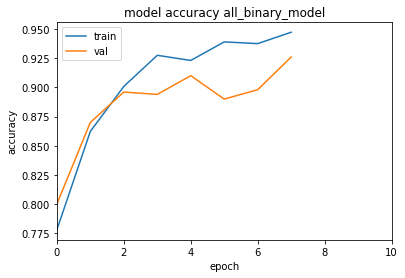

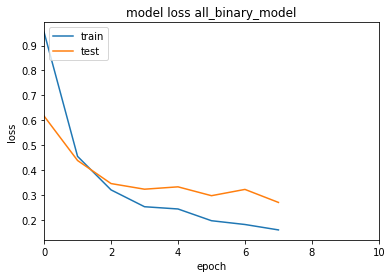

In [35]:
plot_loss_acc(train_loss, train_acc, val_loss, val_acc, 'MN_no_binary')

## Test:

In [9]:
# load model pretrained on Omniglot:
model = NoBinaryMatchingNetwork(n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()
model.load_state_dict(load(f'trained_models/Omniglot/matching_nets/NoBinary/{param_str}.pth'))

use 1 gpu who named: Tesla P100-PCIE-16GB


<All keys matched successfully>

In [0]:
print(model)

In [13]:
# test model on evaluation dataset:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks_test = [
    EvaluateFewShot(
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
]

fit(
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=5,
    dataloader=evaluation_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
    callbacks=callbacks_test,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_test, 'k_way': k_test, 'q_queries': q_test, 'distance': distance, 'train': False}
)

Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Begin training...


Epoch 3: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it, loss=0.22, categorical_accuracy=0.92]

Finished.


## Visualization:

### Create model & load pretrained model:

### Filters visualization:

### Activations visualization:

### Heatmap visualization:

# Binary Omniglot:

## Parameters:

In [0]:
##############
# Parameters #
##############
first_binary_conv_layer = True
second_binary_conv_layer = False
third_binary_conv_layer = False
fourth_binary_conv_layer = False

## Model

In [0]:
#########
# Model #
#########
model = BinaryMatchingNetwork(first_binary_conv_layer, second_binary_conv_layer,
                              third_binary_conv_layer, fourth_binary_conv_layer,
                              n_train, k_train, q_train, num_input_channels)
model, use_gpu = gpu_config(model)
model.double()

## DataLoader:

In [0]:
###########
# Dataset #
###########
background_taskloader, evaluation_taskloader = get_omniglot_dataloader_v2(episodes_per_epoch, n_train, k_train,
                                                                          q_train, n_test, k_test, q_test,
                                                                          dataset_class)

## Training:

In [0]:
optimiser = Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss().cuda()

callbacks = [
    EvaluateFewShot(
        eval_fn=matching_net_episode,
        num_tasks=evaluation_episodes,
        n_shot=n_test,
        k_way=k_test,
        q_queries=q_test,
        taskloader=evaluation_taskloader,
        prepare_batch=prepare_nshot_task(use_gpu, n_test, k_test, q_test),
        distance=distance
    ),
    ModelCheckpoint(
        filepath=PATH + f'/trained_models/Omniglot/matching_nets/Binary/{param_str}.pth',
        monitor=f'val_{n_test}-shot_{k_test}-way_acc',
        # monitor=f'val_loss',
    ),
    ReduceLROnPlateau(patience=20, factor=0.5, monitor=f'val_{n_test}-shot_{k_test}-way_acc'),
    CSVLogger(PATH + f'/results/Omniglot_results/logs/matching_nets/Binary/{param_str}.csv'),
]

In [0]:
fit(
    use_gpu,
    model,
    optimiser,
    loss_fn,
    epochs=n_epochs,
    dataloader=background_taskloader,
    prepare_batch=prepare_nshot_task(use_gpu, n_train, k_train, q_train),
    callbacks=callbacks,
    metrics=['categorical_accuracy'],
    fit_function=matching_net_episode,
    fit_function_kwargs={'n_shot': n_train, 'k_way': k_train, 'q_queries': q_train, 'distance': distance, 'train': True}
)

## Plot acc/loss training:

## Test:


## Visualization: